In [ ]:

import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from pathlib import Path

data_path = Path("/kaggle/input/moviedata")

ratings = pd.read_csv(data_path / 'ratings.csv')
movies = pd.read_csv(data_path / 'movies.csv')

# Get unique user and movie counts
user_count = ratings["userId"].nunique()
movie_count = movies["movieId"].nunique()

# Prepare the data for model training
X = ratings[['userId', 'movieId']]
Y = ratings['rating'].astype(np.float32)

# Split the data into training and testing sets
random_state = 7
test_size = 0.2
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)
datasets = {'train': (X_train, Y_train), 'test': (X_test, Y_test)}

In [ ]:
import torch
from torch import nn

class NeuralColabFilteringNet(nn.Module):
    """
    Creates an NCF (Neural Collaborative Filtering) network, with configurable model architecture
    """
    def __init__(self, 
                 user_count,
                 movie_count,
                 embedding_size= 256, 
                 hidden_layers=( 512, 256, 128, 64, 32 ),  
                 dropout_rate=0.6,  
                 output_range=(1, 5)):
        super().__init__()

        # Initialiser les tailles de hachage d'embedding
        self.user_hash_size = user_count
        self.movie_hash_size = movie_count

        # Initialiser les composants de l'architecture du modèle
        self.user_embedding = nn.Embedding(user_count, embedding_size)
        self.movie_embedding = nn.Embedding(movie_count, embedding_size)
        self.MLP = self._gen_MLP(embedding_size, hidden_layers, dropout_rate)

        # Initialiser les paramètres de normalisation de sortie
        assert output_range and len(output_range) == 2, "output_range has to be a tuple with two integers"
        self.norm_min = min(output_range)
        self.norm_range = abs(output_range[0] - output_range[1]) + 1

        self._init_params()

    def _gen_MLP(self, embedding_size, hidden_layers_units, dropout_rate):
        "Generates the MLP portion of the model architecture"
        
        assert (embedding_size * 2) == hidden_layers_units[0], "First input layer number of units has to be equal to twice the embedding size!"
        
        hidden_layers = []
        input_units = hidden_layers_units[0]

        for num_units in hidden_layers_units[1:]:
            hidden_layers.append(nn.Linear(input_units, num_units))
            hidden_layers.append(nn.ReLU())
            if dropout_rate:
                hidden_layers.append(nn.Dropout(dropout_rate))
            input_units = num_units
            
        hidden_layers.append(nn.Linear(hidden_layers_units[-1], 1))
        hidden_layers.append(nn.Sigmoid())
        return nn.Sequential(*hidden_layers)

    def _init_params(self):
        "Initializes model parameters"
        def weights_init(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

        self.user_embedding.weight.data.uniform_(-0.05, 0.05)
        self.movie_embedding.weight.data.uniform_(-0.05, 0.05)
        self.MLP.apply(weights_init)

    def forward(self, user_id, movie_id):
        "Computes forward pass"
        user_features = self.user_embedding(user_id % self.user_hash_size)
        movie_features = self.movie_embedding(movie_id % self.movie_hash_size)
        x = torch.cat([user_features, movie_features], dim=1)
        x = self.MLP(x)
        normalized_output = x * self.norm_range + self.norm_min
        return normalized_output


In [ ]:

ncf = NeuralColabFilteringNet(user_count, movie_count)
print(f"Our model architecture:\n\n{ncf}\n")

num_params = sum(p.numel() for p in ncf.parameters())
print(f'Number of model parameters: {num_params:,}, model training size: {num_params*4/(1024**2):.2f} MB')

# Random prediction for testing
from random import randrange

ratings_row = randrange(0, ratings.shape[0] - 1)
test_user = int(ratings.iloc[ratings_row].userId)
test_movie = int(ratings.iloc[ratings_row].movieId)
actual_rating = ratings.iloc[ratings_row].rating

ncf.to('cpu')
predicted_rating = ncf(torch.tensor([test_user]), torch.tensor([test_movie]))
print(f"Dry run prediction for user-id:{test_user} and movie-id:{test_movie} is: {predicted_rating[0][0]}, actual rating is: {actual_rating}")


Our model architecture:

NeuralColabFilteringNet(
  (user_embedding): Embedding(330975, 256)
  (movie_embedding): Embedding(86537, 256)
  (MLP): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.6, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.6, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.6, inplace=False)
    (9): Linear(in_features=64, out_features=32, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.6, inplace=False)
    (12): Linear(in_features=32, out_features=1, bias=True)
    (13): Sigmoid()
  )
)

Number of model parameters: 107,057,665, model training size: 408.39 MB
Dry run prediction for user-id:20297 and movie-id:4306 is: 3.683058977127075, actual rating is: 3.0


In [ ]:


import numpy as np
import math
import torch

class DatasetBatchIterator:
    def __init__(self, X, Y, batch_size, shuffle=True, device='cpu'):
        """
        Classe pour itérer sur les données par lots.

        :param X: Les données d'entrée.
        :param Y: Les cibles de sortie.
        :param batch_size: Taille du lot.
        :param shuffle: Si vrai, les données sont mélangées.
        :param device: Dispositif pour les tenseurs ('cpu' ou 'cuda').
        """
        self.X = np.asarray(X)
        self.Y = np.asarray(Y)

        if shuffle:
            index = np.random.permutation(X.shape[0])
            self.X = self.X[index]
            self.Y = self.Y[index]

        self.batch_size = batch_size
        self.n_batches = int(np.ceil(X.shape[0] / batch_size))
        self._current = 0 
        self.device = device

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def next(self):
        if self._current >= self.n_batches:
            raise StopIteration()
        k = self._current
        self._current += 1
        bs = self.batch_size
        X_batch = torch.tensor(self.X[k * bs:(k + 1) * bs], dtype=torch.long).to(self.device)
        Y_batch = torch.tensor(self.Y[k * bs:(k + 1) * bs], dtype=torch.float).to(self.device)
        return X_batch, Y_batch.view(-1, 1)

    def __len__(self):
        return self.n_batches 


Train Epoch 1/50: 100%|██████████| 13216/13216 [05:11<00:00, 42.39batch/s]


Epoch [001/050][Time:315.30 sec] Train Loss: 0.8173 - RMSE: 0.9041 - MAE: 0.6938


Test:   0%|          | 0/3304 [00:00<?, ?batch/s]/tmp/ipykernel_29/2286422805.py:159: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Test: 100%|██████████| 3304/3304 [00:03<00:00, 879.98batch/s]


Validation Loss: 0.7391 - RMSE: 0.8597 - MAE: 0.6548


Train Epoch 2/50: 100%|██████████| 13216/13216 [05:11<00:00, 42.38batch/s]


Epoch [002/050][Time:315.28 sec] Train Loss: 0.7652 - RMSE: 0.8748 - MAE: 0.6673


Test: 100%|██████████| 3304/3304 [00:03<00:00, 886.77batch/s]


Validation Loss: 0.7230 - RMSE: 0.8503 - MAE: 0.6459


Train Epoch 3/50: 100%|██████████| 13216/13216 [05:12<00:00, 42.33batch/s]


Epoch [003/050][Time:315.68 sec] Train Loss: 0.7540 - RMSE: 0.8684 - MAE: 0.6623


Test: 100%|██████████| 3304/3304 [00:03<00:00, 907.47batch/s]


Validation Loss: 0.7177 - RMSE: 0.8471 - MAE: 0.6441


Train Epoch 4/50: 100%|██████████| 13216/13216 [05:11<00:00, 42.37batch/s]


Epoch [004/050][Time:315.35 sec] Train Loss: 0.7477 - RMSE: 0.8647 - MAE: 0.6594


Test: 100%|██████████| 3304/3304 [00:03<00:00, 901.42batch/s]


Validation Loss: 0.7115 - RMSE: 0.8435 - MAE: 0.6418


Train Epoch 5/50: 100%|██████████| 13216/13216 [05:11<00:00, 42.37batch/s]


Epoch [005/050][Time:315.35 sec] Train Loss: 0.7437 - RMSE: 0.8624 - MAE: 0.6575


Test: 100%|██████████| 3304/3304 [00:03<00:00, 902.65batch/s]


Validation Loss: 0.7054 - RMSE: 0.8399 - MAE: 0.6356


Train Epoch 6/50: 100%|██████████| 13216/13216 [05:11<00:00, 42.38batch/s]


Epoch [006/050][Time:315.29 sec] Train Loss: 0.7413 - RMSE: 0.8610 - MAE: 0.6565


Test: 100%|██████████| 3304/3304 [00:03<00:00, 898.17batch/s]


Validation Loss: 0.7047 - RMSE: 0.8395 - MAE: 0.6364


Train Epoch 7/50: 100%|██████████| 13216/13216 [05:11<00:00, 42.37batch/s]


Epoch [007/050][Time:315.33 sec] Train Loss: 0.7396 - RMSE: 0.8600 - MAE: 0.6558


Test: 100%|██████████| 3304/3304 [00:03<00:00, 905.53batch/s]


Validation Loss: 0.7026 - RMSE: 0.8382 - MAE: 0.6374


Train Epoch 8/50: 100%|██████████| 13216/13216 [05:12<00:00, 42.35batch/s]


Epoch [008/050][Time:315.49 sec] Train Loss: 0.7376 - RMSE: 0.8588 - MAE: 0.6548


Test: 100%|██████████| 3304/3304 [00:03<00:00, 899.39batch/s]


Validation Loss: 0.7015 - RMSE: 0.8376 - MAE: 0.6362


Train Epoch 9/50: 100%|██████████| 13216/13216 [05:12<00:00, 42.36batch/s]


Epoch [009/050][Time:315.45 sec] Train Loss: 0.7351 - RMSE: 0.8574 - MAE: 0.6539


Test: 100%|██████████| 3304/3304 [00:03<00:00, 905.80batch/s]


Validation Loss: 0.6978 - RMSE: 0.8353 - MAE: 0.6356


Train Epoch 10/50: 100%|██████████| 13216/13216 [05:11<00:00, 42.37batch/s]


Epoch [010/050][Time:315.37 sec] Train Loss: 0.7328 - RMSE: 0.8561 - MAE: 0.6529


Test: 100%|██████████| 3304/3304 [00:03<00:00, 874.68batch/s]


Validation Loss: 0.6977 - RMSE: 0.8353 - MAE: 0.6355


Train Epoch 11/50: 100%|██████████| 13216/13216 [05:11<00:00, 42.40batch/s]


Epoch [011/050][Time:315.07 sec] Train Loss: 0.6975 - RMSE: 0.8351 - MAE: 0.6354


Test: 100%|██████████| 3304/3304 [00:03<00:00, 896.50batch/s]


Validation Loss: 0.6718 - RMSE: 0.8196 - MAE: 0.6206


Train Epoch 12/50: 100%|██████████| 13216/13216 [05:11<00:00, 42.41batch/s]


Epoch [012/050][Time:315.02 sec] Train Loss: 0.6816 - RMSE: 0.8256 - MAE: 0.6272


Test: 100%|██████████| 3304/3304 [00:03<00:00, 896.72batch/s]


Validation Loss: 0.6641 - RMSE: 0.8149 - MAE: 0.6163


Train Epoch 13/50: 100%|██████████| 13216/13216 [05:11<00:00, 42.37batch/s]


Epoch [013/050][Time:315.34 sec] Train Loss: 0.6723 - RMSE: 0.8200 - MAE: 0.6226


Test: 100%|██████████| 3304/3304 [00:03<00:00, 902.16batch/s]


Validation Loss: 0.6584 - RMSE: 0.8114 - MAE: 0.6129


Train Epoch 14/50: 100%|██████████| 13216/13216 [05:11<00:00, 42.39batch/s]


Epoch [014/050][Time:315.23 sec] Train Loss: 0.6656 - RMSE: 0.8158 - MAE: 0.6193


Test: 100%|██████████| 3304/3304 [00:03<00:00, 906.02batch/s]


Validation Loss: 0.6550 - RMSE: 0.8093 - MAE: 0.6118


Train Epoch 15/50: 100%|██████████| 13216/13216 [05:11<00:00, 42.43batch/s]


Epoch [015/050][Time:314.93 sec] Train Loss: 0.6602 - RMSE: 0.8125 - MAE: 0.6167


Test: 100%|██████████| 3304/3304 [00:03<00:00, 898.59batch/s]


Validation Loss: 0.6527 - RMSE: 0.8079 - MAE: 0.6104


Train Epoch 16/50: 100%|██████████| 13216/13216 [05:11<00:00, 42.41batch/s]


Epoch [016/050][Time:315.08 sec] Train Loss: 0.6560 - RMSE: 0.8099 - MAE: 0.6146


Test: 100%|██████████| 3304/3304 [00:03<00:00, 907.10batch/s]


Validation Loss: 0.6508 - RMSE: 0.8067 - MAE: 0.6099


Train Epoch 17/50: 100%|██████████| 13216/13216 [05:11<00:00, 42.44batch/s]


Epoch [017/050][Time:314.85 sec] Train Loss: 0.6522 - RMSE: 0.8076 - MAE: 0.6128


Test: 100%|██████████| 3304/3304 [00:03<00:00, 901.72batch/s]


Validation Loss: 0.6489 - RMSE: 0.8056 - MAE: 0.6076


Train Epoch 18/50: 100%|██████████| 13216/13216 [05:11<00:00, 42.40batch/s]


Epoch [018/050][Time:315.13 sec] Train Loss: 0.6492 - RMSE: 0.8057 - MAE: 0.6112


Test: 100%|██████████| 3304/3304 [00:03<00:00, 890.02batch/s]


Validation Loss: 0.6478 - RMSE: 0.8049 - MAE: 0.6075


Train Epoch 19/50: 100%|██████████| 13216/13216 [05:11<00:00, 42.41batch/s]


Epoch [019/050][Time:315.07 sec] Train Loss: 0.6463 - RMSE: 0.8039 - MAE: 0.6099


Test: 100%|██████████| 3304/3304 [00:03<00:00, 887.66batch/s]


Validation Loss: 0.6470 - RMSE: 0.8043 - MAE: 0.6073


Train Epoch 20/50: 100%|██████████| 13216/13216 [05:11<00:00, 42.44batch/s]


Epoch [020/050][Time:314.79 sec] Train Loss: 0.6436 - RMSE: 0.8022 - MAE: 0.6086


Test: 100%|██████████| 3304/3304 [00:03<00:00, 896.92batch/s]


Validation Loss: 0.6457 - RMSE: 0.8036 - MAE: 0.6065


Train Epoch 21/50: 100%|██████████| 13216/13216 [05:11<00:00, 42.42batch/s]


Epoch [021/050][Time:314.99 sec] Train Loss: 0.6242 - RMSE: 0.7900 - MAE: 0.5985


Test: 100%|██████████| 3304/3304 [00:03<00:00, 906.62batch/s]


Validation Loss: 0.6457 - RMSE: 0.8035 - MAE: 0.6059


Train Epoch 22/50: 100%|██████████| 13216/13216 [05:11<00:00, 42.41batch/s]


Epoch [022/050][Time:315.06 sec] Train Loss: 0.6201 - RMSE: 0.7874 - MAE: 0.5962


Test: 100%|██████████| 3304/3304 [00:03<00:00, 907.85batch/s]


Validation Loss: 0.6450 - RMSE: 0.8031 - MAE: 0.6049


Train Epoch 23/50: 100%|██████████| 13216/13216 [05:11<00:00, 42.40batch/s]


Epoch [023/050][Time:315.15 sec] Train Loss: 0.6173 - RMSE: 0.7857 - MAE: 0.5946


Test: 100%|██████████| 3304/3304 [00:03<00:00, 908.16batch/s]


Validation Loss: 0.6445 - RMSE: 0.8028 - MAE: 0.6045


Train Epoch 24/50: 100%|██████████| 13216/13216 [05:11<00:00, 42.40batch/s]


Epoch [024/050][Time:315.08 sec] Train Loss: 0.6148 - RMSE: 0.7841 - MAE: 0.5933


Test: 100%|██████████| 3304/3304 [00:03<00:00, 899.63batch/s]


Validation Loss: 0.6442 - RMSE: 0.8027 - MAE: 0.6045


Train Epoch 25/50: 100%|██████████| 13216/13216 [05:11<00:00, 42.41batch/s]


Epoch [025/050][Time:315.00 sec] Train Loss: 0.6124 - RMSE: 0.7826 - MAE: 0.5920


Test: 100%|██████████| 3304/3304 [00:03<00:00, 900.71batch/s]


Validation Loss: 0.6440 - RMSE: 0.8025 - MAE: 0.6040


Train Epoch 26/50: 100%|██████████| 13216/13216 [05:11<00:00, 42.42batch/s]


Epoch [026/050][Time:314.94 sec] Train Loss: 0.6103 - RMSE: 0.7812 - MAE: 0.5908


Test: 100%|██████████| 3304/3304 [00:03<00:00, 895.98batch/s]


Validation Loss: 0.6441 - RMSE: 0.8026 - MAE: 0.6042


Train Epoch 27/50: 100%|██████████| 13216/13216 [05:11<00:00, 42.43batch/s]


Epoch [027/050][Time:314.89 sec] Train Loss: 0.6083 - RMSE: 0.7800 - MAE: 0.5897


Test: 100%|██████████| 3304/3304 [00:03<00:00, 893.61batch/s]


Validation Loss: 0.6439 - RMSE: 0.8024 - MAE: 0.6040


Train Epoch 28/50: 100%|██████████| 13216/13216 [05:11<00:00, 42.43batch/s]


Epoch [028/050][Time:314.93 sec] Train Loss: 0.6065 - RMSE: 0.7788 - MAE: 0.5887


Test: 100%|██████████| 3304/3304 [00:03<00:00, 884.04batch/s]


Validation Loss: 0.6438 - RMSE: 0.8023 - MAE: 0.6037


Train Epoch 29/50: 100%|██████████| 13216/13216 [05:11<00:00, 42.42batch/s]


Epoch [029/050][Time:314.96 sec] Train Loss: 0.6047 - RMSE: 0.7777 - MAE: 0.5877


Test: 100%|██████████| 3304/3304 [00:03<00:00, 904.15batch/s]


Validation Loss: 0.6437 - RMSE: 0.8023 - MAE: 0.6034


Train Epoch 30/50: 100%|██████████| 13216/13216 [05:11<00:00, 42.41batch/s]


Epoch [030/050][Time:315.07 sec] Train Loss: 0.6031 - RMSE: 0.7766 - MAE: 0.5869


Test: 100%|██████████| 3304/3304 [00:03<00:00, 909.41batch/s]


Validation Loss: 0.6436 - RMSE: 0.8023 - MAE: 0.6034


Train Epoch 31/50: 100%|██████████| 13216/13216 [05:11<00:00, 42.43batch/s]


Epoch [031/050][Time:314.92 sec] Train Loss: 0.5985 - RMSE: 0.7736 - MAE: 0.5843


Test: 100%|██████████| 3304/3304 [00:03<00:00, 906.75batch/s]


Validation Loss: 0.6440 - RMSE: 0.8025 - MAE: 0.6035


Train Epoch 32/50: 100%|██████████| 13216/13216 [05:11<00:00, 42.42batch/s]


Epoch [032/050][Time:314.93 sec] Train Loss: 0.5982 - RMSE: 0.7735 - MAE: 0.5841


Test: 100%|██████████| 3304/3304 [00:03<00:00, 905.61batch/s]


Validation Loss: 0.6442 - RMSE: 0.8026 - MAE: 0.6036


Train Epoch 33/50: 100%|██████████| 13216/13216 [05:11<00:00, 42.41batch/s]


Epoch [033/050][Time:315.01 sec] Train Loss: 0.5979 - RMSE: 0.7732 - MAE: 0.5840


Test: 100%|██████████| 3304/3304 [00:03<00:00, 892.80batch/s]


Validation Loss: 0.6442 - RMSE: 0.8026 - MAE: 0.6036


Train Epoch 34/50: 100%|██████████| 13216/13216 [05:11<00:00, 42.44batch/s]


Epoch [034/050][Time:314.82 sec] Train Loss: 0.5976 - RMSE: 0.7731 - MAE: 0.5838


Test: 100%|██████████| 3304/3304 [00:03<00:00, 897.01batch/s]


Validation Loss: 0.6443 - RMSE: 0.8027 - MAE: 0.6036


Train Epoch 35/50: 100%|██████████| 13216/13216 [05:11<00:00, 42.42batch/s]


Epoch [035/050][Time:315.02 sec] Train Loss: 0.5973 - RMSE: 0.7729 - MAE: 0.5837


Test: 100%|██████████| 3304/3304 [00:03<00:00, 892.44batch/s]


Validation Loss: 0.6442 - RMSE: 0.8026 - MAE: 0.6036


Train Epoch 36/50: 100%|██████████| 13216/13216 [05:11<00:00, 42.42batch/s]


Epoch [036/050][Time:314.95 sec] Train Loss: 0.5971 - RMSE: 0.7727 - MAE: 0.5836


Test: 100%|██████████| 3304/3304 [00:03<00:00, 896.89batch/s]


Validation Loss: 0.6443 - RMSE: 0.8027 - MAE: 0.6036


Train Epoch 37/50: 100%|██████████| 13216/13216 [05:11<00:00, 42.43batch/s]


Epoch [037/050][Time:315.08 sec] Train Loss: 0.5968 - RMSE: 0.7725 - MAE: 0.5834


Test: 100%|██████████| 3304/3304 [00:03<00:00, 880.29batch/s]


Validation Loss: 0.6443 - RMSE: 0.8027 - MAE: 0.6036


Train Epoch 38/50: 100%|██████████| 13216/13216 [05:11<00:00, 42.43batch/s]


Epoch [038/050][Time:314.89 sec] Train Loss: 0.5963 - RMSE: 0.7722 - MAE: 0.5831


Test: 100%|██████████| 3304/3304 [00:03<00:00, 910.62batch/s]


Validation Loss: 0.6443 - RMSE: 0.8027 - MAE: 0.6036


Train Epoch 39/50: 100%|██████████| 13216/13216 [05:11<00:00, 42.44batch/s]


Epoch [039/050][Time:314.79 sec] Train Loss: 0.5964 - RMSE: 0.7723 - MAE: 0.5831


Test: 100%|██████████| 3304/3304 [00:03<00:00, 907.49batch/s]


Validation Loss: 0.6443 - RMSE: 0.8027 - MAE: 0.6036


Train Epoch 40/50: 100%|██████████| 13216/13216 [05:11<00:00, 42.41batch/s]


Epoch [040/050][Time:315.02 sec] Train Loss: 0.5962 - RMSE: 0.7722 - MAE: 0.5830


Test: 100%|██████████| 3304/3304 [00:03<00:00, 894.11batch/s]


Validation Loss: 0.6443 - RMSE: 0.8027 - MAE: 0.6036


Train Epoch 41/50: 100%|██████████| 13216/13216 [05:11<00:00, 42.42batch/s]


Epoch [041/050][Time:314.94 sec] Train Loss: 0.5955 - RMSE: 0.7717 - MAE: 0.5827


Test: 100%|██████████| 3304/3304 [00:03<00:00, 898.85batch/s]


Validation Loss: 0.6443 - RMSE: 0.8027 - MAE: 0.6036


Train Epoch 42/50: 100%|██████████| 13216/13216 [05:11<00:00, 42.42batch/s]


Epoch [042/050][Time:314.99 sec] Train Loss: 0.5956 - RMSE: 0.7718 - MAE: 0.5827


Test: 100%|██████████| 3304/3304 [00:03<00:00, 896.12batch/s]


Validation Loss: 0.6444 - RMSE: 0.8027 - MAE: 0.6036


Train Epoch 43/50: 100%|██████████| 13216/13216 [05:11<00:00, 42.39batch/s]


Epoch [043/050][Time:315.16 sec] Train Loss: 0.5955 - RMSE: 0.7717 - MAE: 0.5827


Test: 100%|██████████| 3304/3304 [00:03<00:00, 905.89batch/s]


Validation Loss: 0.6444 - RMSE: 0.8027 - MAE: 0.6036


Train Epoch 44/50: 100%|██████████| 13216/13216 [05:11<00:00, 42.43batch/s]


Epoch [044/050][Time:314.92 sec] Train Loss: 0.5956 - RMSE: 0.7718 - MAE: 0.5827


Test: 100%|██████████| 3304/3304 [00:03<00:00, 904.11batch/s]


Validation Loss: 0.6444 - RMSE: 0.8027 - MAE: 0.6036


Train Epoch 45/50: 100%|██████████| 13216/13216 [05:11<00:00, 42.41batch/s]


Epoch [045/050][Time:315.03 sec] Train Loss: 0.5956 - RMSE: 0.7717 - MAE: 0.5827


Test: 100%|██████████| 3304/3304 [00:03<00:00, 906.32batch/s]


Validation Loss: 0.6444 - RMSE: 0.8027 - MAE: 0.6036


Train Epoch 46/50: 100%|██████████| 13216/13216 [05:11<00:00, 42.43batch/s]


Epoch [046/050][Time:314.90 sec] Train Loss: 0.5953 - RMSE: 0.7716 - MAE: 0.5826


Test: 100%|██████████| 3304/3304 [00:03<00:00, 891.82batch/s]


Validation Loss: 0.6444 - RMSE: 0.8027 - MAE: 0.6036


Train Epoch 47/50: 100%|██████████| 13216/13216 [05:11<00:00, 42.42batch/s]


Epoch [047/050][Time:314.97 sec] Train Loss: 0.5953 - RMSE: 0.7716 - MAE: 0.5826


Test: 100%|██████████| 3304/3304 [00:03<00:00, 888.10batch/s]


Validation Loss: 0.6444 - RMSE: 0.8027 - MAE: 0.6036


Train Epoch 48/50: 100%|██████████| 13216/13216 [05:11<00:00, 42.40batch/s]


Epoch [048/050][Time:315.09 sec] Train Loss: 0.5954 - RMSE: 0.7716 - MAE: 0.5826


Test: 100%|██████████| 3304/3304 [00:03<00:00, 899.51batch/s]


Validation Loss: 0.6444 - RMSE: 0.8028 - MAE: 0.6036


Train Epoch 49/50: 100%|██████████| 13216/13216 [05:11<00:00, 42.45batch/s]


Epoch [049/050][Time:314.72 sec] Train Loss: 0.5953 - RMSE: 0.7716 - MAE: 0.5826


Test: 100%|██████████| 3304/3304 [00:03<00:00, 896.13batch/s]


Validation Loss: 0.6444 - RMSE: 0.8028 - MAE: 0.6036


Train Epoch 50/50: 100%|██████████| 13216/13216 [05:11<00:00, 42.41batch/s]


Epoch [050/050][Time:314.99 sec] Train Loss: 0.5953 - RMSE: 0.7715 - MAE: 0.5826


Test: 100%|██████████| 3304/3304 [00:03<00:00, 911.00batch/s]


Validation Loss: 0.6444 - RMSE: 0.8028 - MAE: 0.6036


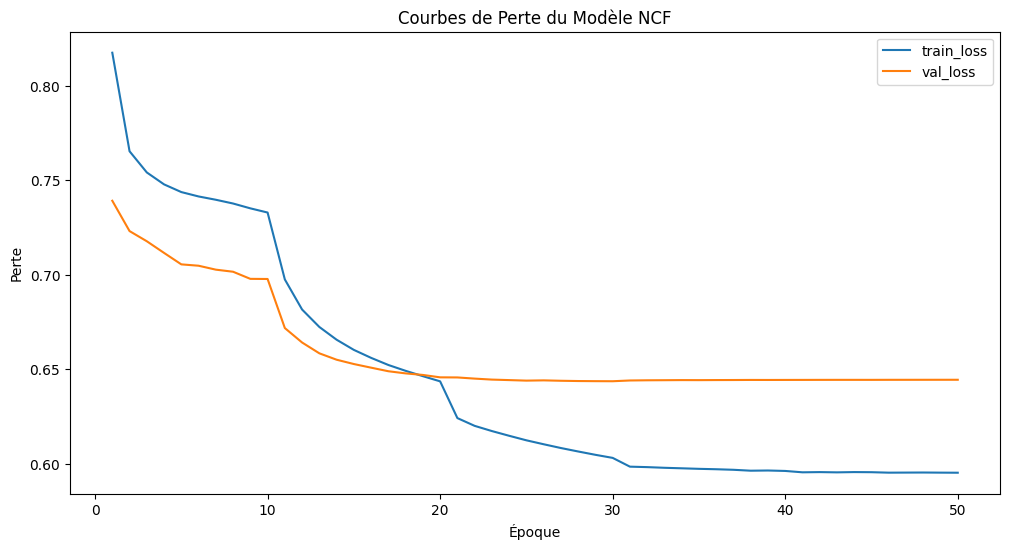

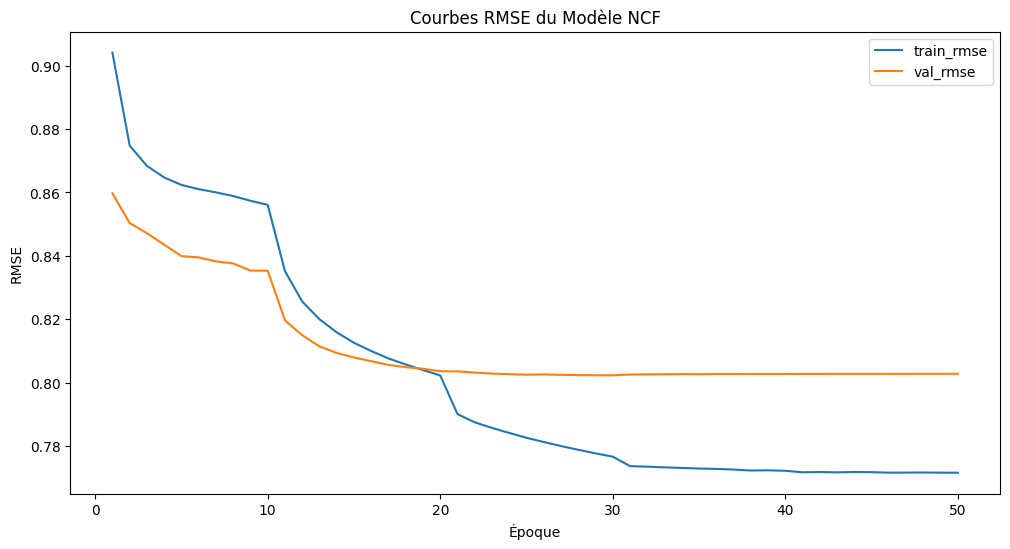

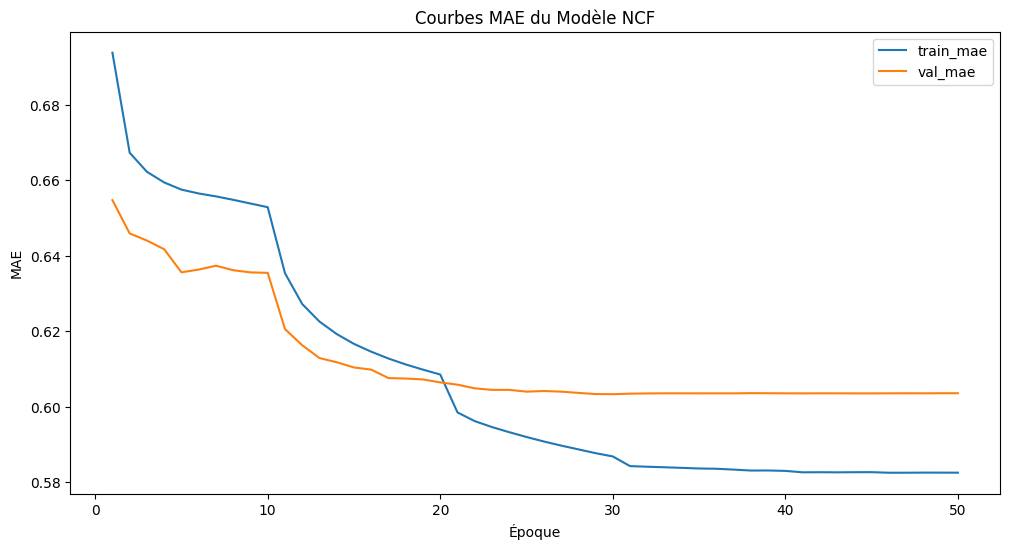

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Configuration de l'entraînement
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ncf = NeuralColabFilteringNet(user_count, movie_count).to(device)  # Remplacez par vos paramètres de modèle
optimizer = optim.Adam(ncf.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
scaler = torch.amp.GradScaler()
epochs = 50
batch_size = 2048

# Structure pour stocker les métriques par époque
history = {'epoch': [], 'train_loss': [], 'train_rmse': [], 'train_mae': [], 'val_loss': [], 'val_rmse': [], 'val_mae': []}

# Boucle d'entraînement
for epoch in range(epochs):
    epoch_start_time = time.perf_counter()
    ncf.train()
    running_loss, total_squared_error, total_absolute_error, n_samples = 0.0, 0.0, 0.0, 0

    train_loader = DatasetBatchIterator(datasets['train'][0], datasets['train'][1], batch_size=batch_size)
    for x_batch, y_batch in tqdm(train_loader, desc=f"Train Epoch {epoch + 1}/{epochs}", unit="batch"):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda'):
            outputs = ncf(x_batch[:, 0], x_batch[:, 1])
            loss = criterion(outputs, y_batch)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        total_squared_error += torch.sum((outputs - y_batch) ** 2).item()
        total_absolute_error += torch.sum(torch.abs(outputs - y_batch)).item()
        n_samples += len(y_batch)

    scheduler.step()  
    average_train_loss = running_loss / len(train_loader)
    average_rmse = (total_squared_error / n_samples) ** 0.5
    average_mae = total_absolute_error / n_samples
    epoch_duration = time.perf_counter() - epoch_start_time

    print(f"Epoch [{epoch + 1:03d}/{epochs:03d}][Time:{epoch_duration:.2f} sec] "
          f"Train Loss: {average_train_loss:.4f} - RMSE: {average_rmse:.4f} - MAE: {average_mae:.4f}")

    # Évaluation sur l'ensemble de test
    ncf.eval()
    test_loss, total_squared_error, total_absolute_error, n_samples = 0.0, 0.0, 0.0, 0
    with torch.no_grad():
        test_loader = DatasetBatchIterator(datasets['test'][0], datasets['test'][1], batch_size=batch_size, shuffle=False)
        for x_batch, y_batch in tqdm(test_loader, desc="Test", unit="batch"):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            with torch.cuda.amp.autocast():
                outputs = ncf(x_batch[:, 0], x_batch[:, 1])
                loss = criterion(outputs, y_batch)

            # Calcul des métriques de test
            test_loss += loss.item()
            total_squared_error += torch.sum((outputs - y_batch) ** 2).item()
            total_absolute_error += torch.sum(torch.abs(outputs - y_batch)).item()
            n_samples += len(y_batch)

    average_test_loss = test_loss / len(test_loader)
    average_test_rmse = (total_squared_error / n_samples) ** 0.5
    average_test_mae = total_absolute_error / n_samples

    # Enregistrer les métriques de l'époque actuelle dans history
    history['epoch'].append(epoch + 1)
    history['train_loss'].append(average_train_loss)
    history['train_rmse'].append(average_rmse)
    history['train_mae'].append(average_mae)
    history['val_loss'].append(average_test_loss)
    history['val_rmse'].append(average_test_rmse)
    history['val_mae'].append(average_test_mae)

    print(f"Validation Loss: {average_test_loss:.4f} - RMSE: {average_test_rmse:.4f} - MAE: {average_test_mae:.4f}")

# Création du DataFrame pour visualiser les métriques de chaque époque
df_history = pd.DataFrame(history)

# Tracé des courbes de perte pour chaque époque
df_history.plot(x='epoch', y=['train_loss', 'val_loss'], figsize=(12, 6), title="Courbes de Perte du Modèle NCF")
plt.xlabel("Époque")
plt.ylabel("Perte")
plt.show()

# Tracé des courbes RMSE pour chaque époque
df_history.plot(x='epoch', y=['train_rmse', 'val_rmse'], figsize=(12, 6), title="Courbes RMSE du Modèle NCF")
plt.xlabel("Époque")
plt.ylabel("RMSE")
plt.show()

# Tracé des courbes MAE pour chaque époque
df_history.plot(x='epoch', y=['train_mae', 'val_mae'], figsize=(12, 6), title="Courbes MAE du Modèle NCF")
plt.xlabel("Époque")
plt.ylabel("MAE")
plt.show()


In [22]:
import os
torch.save(ncf.state_dict(), "/kaggle/working/model512.pth")

print(os.listdir("/kaggle/working"))

['model5.pth', '.virtual_documents', 'model512.pth']


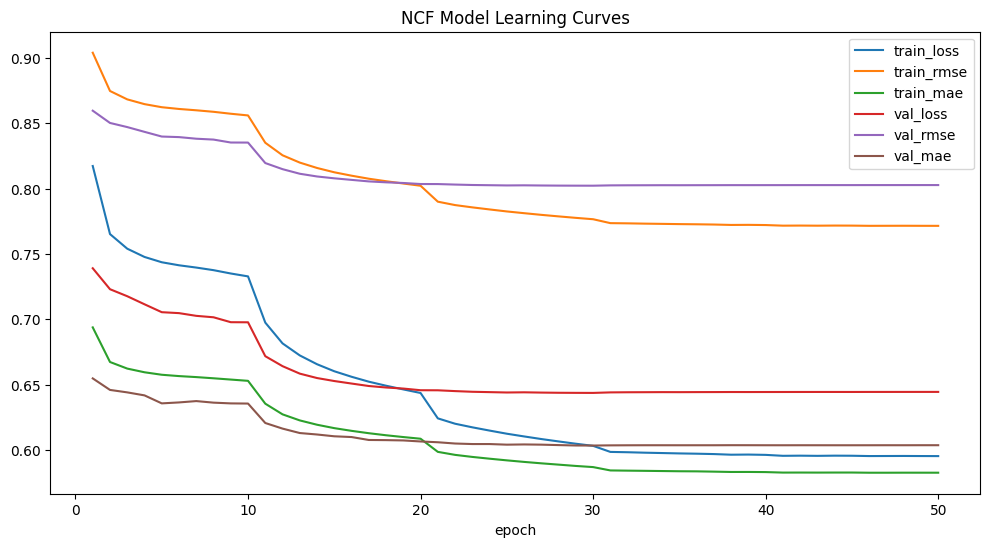

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history).plot(x='epoch', figsize=(12, 6), title="NCF Model Learning Curves")
plt.show()


In [ ]:
# Importer les bibliothèques nécessaires
import torch
import numpy as np
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ncf = NeuralColabFilteringNet(user_count, movie_count)
ncf.load_state_dict(torch.load("/kaggle/working/model512.pth", map_location=device))
ncf.to(device) 
ncf.eval()  

# Définir la fonction pour évaluer le modèle
def evaluate_model(model, dataset):
    running_loss = 0.0
    running_rmse = 0.0
    running_mae = 0.0
    running_accuracy = 0.0
    n_batches = 0
    loss_criterion = nn.MSELoss(reduction='sum')

    with torch.no_grad():  
        for x_batch, y_batch in DatasetBatchIterator(dataset[0], dataset[1], batch_size=2046, shuffle=False):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)  
            user_id, movie_id = x_batch[:, 0], x_batch[:, 1]  

            outputs = model(user_id, movie_id)  
            loss = loss_criterion(outputs, y_batch)

            running_loss += loss.item()
            batch_rmse = torch.sqrt(loss / len(y_batch)).item()
            batch_mae = torch.mean(torch.abs(outputs - y_batch)).item()
            
            predictions = outputs.detach().cpu().numpy()
            targets = y_batch.detach().cpu().numpy()
            correct_predictions = np.sum(np.abs(predictions - targets) < 0.5) 
            running_accuracy += correct_predictions / len(targets)

            running_rmse += batch_rmse
            running_mae += batch_mae
            n_batches += 1

    # Calculer la perte, RMSE, MAE et l'accuracy moyenne pour toutes les données
    epoch_loss = running_loss / len(dataset[0])
    epoch_rmse = running_rmse / n_batches
    epoch_mae = running_mae / n_batches
    epoch_accuracy = running_accuracy / n_batches

    return epoch_loss, epoch_rmse, epoch_mae, epoch_accuracy

# Évaluer le modèle sur les ensembles d'entraînement et de test
train_loss, train_rmse, train_mae, train_accuracy = evaluate_model(ncf, datasets['train'])
test_loss, test_rmse, test_mae, test_accuracy = evaluate_model(ncf, datasets['test'])

# Afficher les résultats
print(f"Training Loss: {train_loss:.4f}, RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, Accuracy: {train_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}, RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, Accuracy: {test_accuracy:.4f}")

/tmp/ipykernel_29/3937287654.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ncf.load_state_dict(torch.load("/kaggle/working/model512.pth", map_location=device))


Training Loss: 0.5305, RMSE: 0.7282, MAE: 0.5459, Accuracy: 0.5646
Test Loss: 0.6444, RMSE: 0.8026, MAE: 0.6036, Accuracy: 0.5237
